# TOF Sensor Outdoor Tests

## Objective

This notebook aims to assess the TOF sensor's capability in accurately detecting and measuring distances of vehicles in real-world conditions.

## Experiment Details

### Experiment Setup

1. **Stationary Test**: The sensor was initially mounted on a stationary bike alongside a bustling road to gauge its proficiency in detecting passing vehicles.
2. **Dynamic Test**: Retaining the setup, the bike was ridden on various roads, collecting data from vehicles overtaking the cyclist. This step transitioned the evaluation from a controlled setting to a more dynamic environment, offering insights into real-world applicability.

### Data Extraction

Data from the sensor was published over to AWS IoT's message broker via MQTT. I then extracted the data in to text files. Each line of measurement contains the time, distance, and signal strength:

```text
10:45:37 1623 4
```

-1 values indicate null points where data wasn't captured reliably.

```text
10:45:38 -1 0
```

## Technical Insights

1. **Sensor Frequency**: As per WaveShare's documentation, the sensor operates at a frequency of 10Hz, translating to 10 measurements every second.
2. **Vehicle Assumptions**:
    - Average Speed: Cyclist at 25km/h and Car at 50km/h.
    - Average Length: Bicycle at 2m and Car at 4m.
  
    ![Equation](../assets/screenshots/Equation.png)

Given the above, the sensor is estimated to log 2-3 points on average for each passing car. The actual points may vary based on the relative velocities and sizes of the vehicles.

## Code Setup

### Imports

To maintain a clean and organized notebook, various functionalities have been distributed into separate Python modules:

- [`cleaner.py`](../src/data/cleaner.py) includes data cleaning functions.
- [`loader.py`](../src/data/loader.py) aids in extracting sensor data from text files.
- [`basic_graphs.py`](../src/graphing/outdoor_graphs.py) provides utilities for data visualization.

In [1]:
import pathlib

import matplotlib.pyplot as plt

from cycling_safety_analysis.data import cleaner, loader
from cycling_safety_analysis.graphing import outdoor_graphs

### Data Preparation and Loading

I first load the data from both stationary and dynamic tests.

In [2]:
STATIONARY_PATH = pathlib.Path("../data/processed/tof_outdoor_tests/stationary_test.txt")
LAKESIDE_RD_PATH = pathlib.Path("../data/processed/tof_outdoor_tests/lakeside_drive.txt")

## Stationary Test

In the initial test, the sensor was mounted on a stationary bike along Corporation Rd., an area with moderate traffic. A GoPro was also set up to record passing vehicles. By comparing the sensor's data with the GoPro footage, we assessed the sensor's reliability.

### Raw Data Analysis

- **Scatter Plot Observations**: The scatter plot below showcases all the distances the sensor measured. While there are clear clusters representing passing vehicles, the volume of spurious data is notably high.
- **Data Cleaning Objective**: The primary goal of data cleaning was to eliminate these irrelevant points without affecting the genuine clusters indicative of passing vehicles.

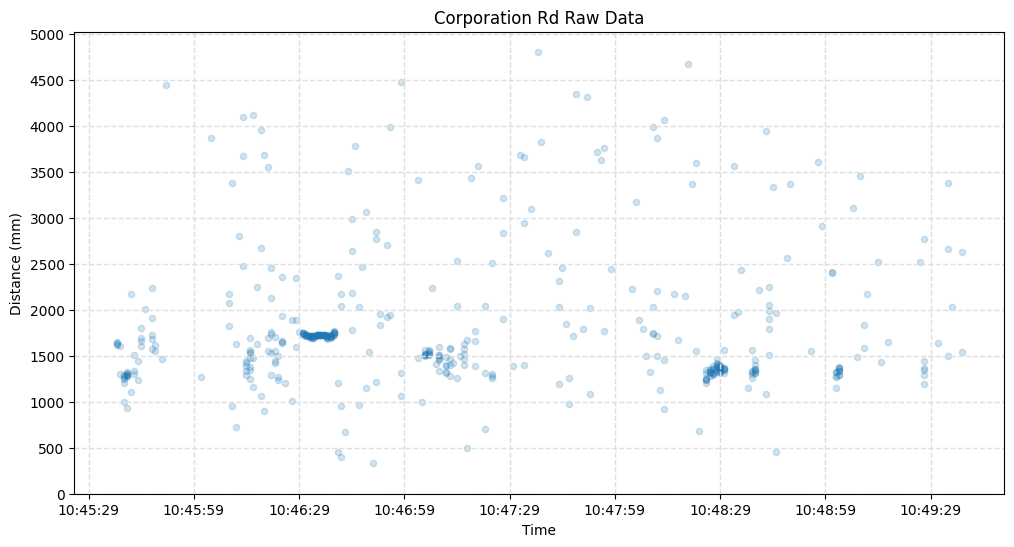

In [3]:
timing, distances, strengths = loader.load_data_from_file(STATIONARY_PATH, clean=False)
fig, axes = plt.subplots(figsize=(12, 6))
outdoor_graphs.scatter_time_vs_distance(axes, timing, distances, "Corporation Rd Raw Data")
plt.show()

### Data Cleaning Algorithm

- **Distance Constraint**: All points beyond a 2.5m distance were removed. Preliminary tests highlighted the sensor's unreliability in daylight beyond this distance. Additionally, for the project's objective, measurements beyond 2.5m were not crucial.
- **Cluster Identification**: Distances that weren't in proximity (within two points) of other distances were removed, ensuring a minimum cluster size of 2 points.
- **Graphical Representation**:
    - The first graph showcases the cleaned data, which now more prominently displays clusters representing vehicle passes.
    - The second graph traces the sensor's signal strength over time, showing pronounced spikes aligned with the clusters from the first graph. This correlation suggests the sensor's reliability during vehicle passes.

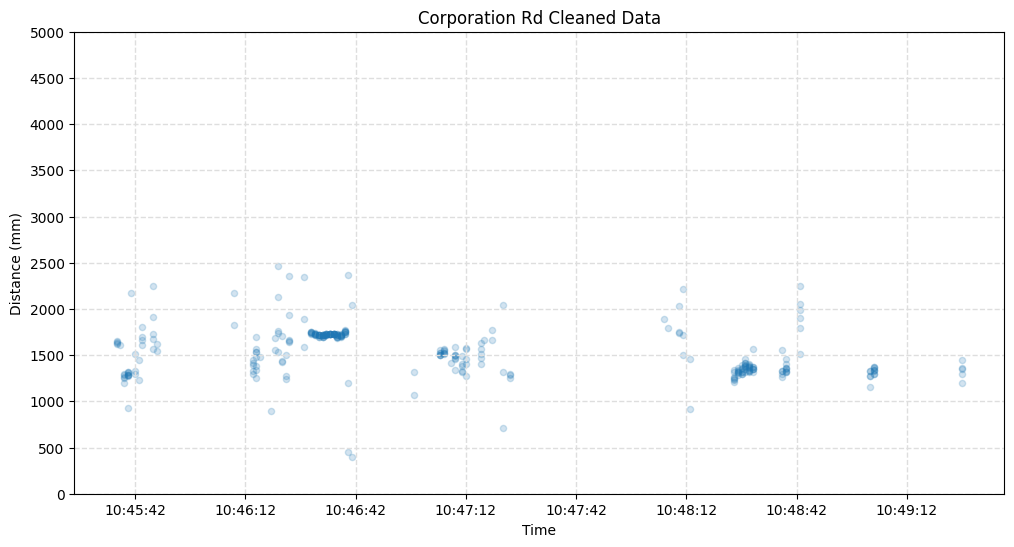

In [4]:
fig, axes = plt.subplots(figsize=(12, 6))

cleaned_distances = cleaner.clean_tof_data(distances)
outdoor_graphs.scatter_time_vs_distance(axes, timing, cleaned_distances, "Corporation Rd Cleaned Data")

### Data Cross-Reference with Video Feed

- **General Observations**:
  - The cleaned data effectively pinpointed the clusters representing passing vehicles.
  - The initial set of points was recorded before the video started.
  - A pronounced cluster at 10:46:30 corresponds to a car that halted adjacent to the sensor due to a red signal.
  - At 10:47:10, the sensor captured a sequence of 8 vehicles.
- **Vehicle Type Analysis**:
  - The following clusters primarily consisted of larger vehicles, such as buses and trucks. The sensor’s performance seemed enhanced with these due to their expansive surface area, affording more measurement time.
  - However, the sensor couldn't distinguish between consecutive vehicles, often merging them into a single cluster.
- **Speed Consideration**: It's worth noting that vehicles on this particular road were relatively slow-moving. This behavior could impact the sensor's performance in different conditions, possibly making it less reliable for faster-moving vehicles.

![Corporation Road](../assets/annotated_graphs/Corporation_Rd.png)

## On-Road Cycling Tests

For a more comprehensive understanding of the sensor's capabilities, I transitioned to real-world conditions. The sensor, complete with its protective casing, was securely attached to a bicycle which was cycled down real roads in Singapore.

### Lakeside Road Analysis

- **Setup and Initial Observations**
  - For this test, I chose Lakeside Rd, characterized by its light vehicular traffic.
  - An initial glance at the scatter plot, representing raw data, highlights that even in such minimal traffic scenarios, the sensor accumulates an overwhelming amount of extraneous data points.

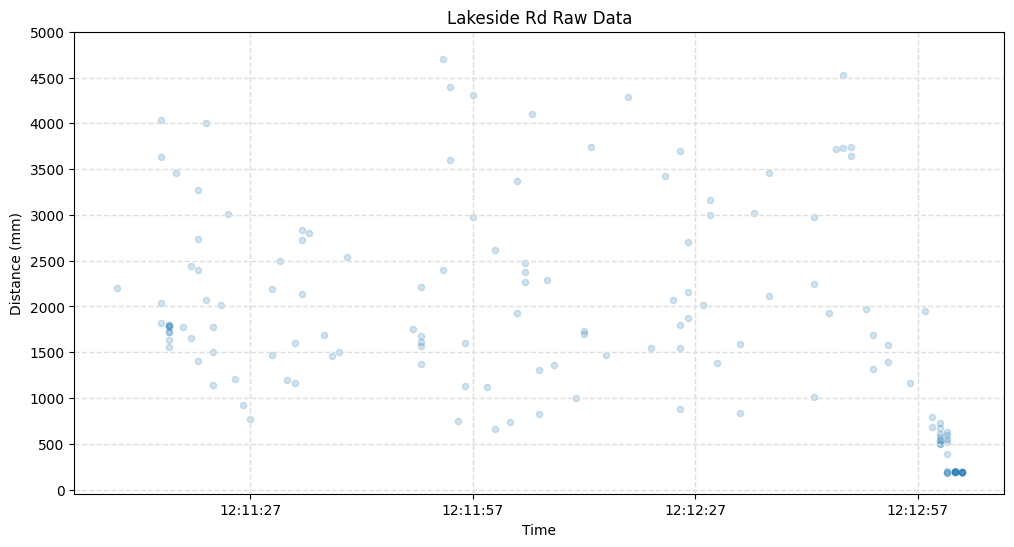

In [6]:
timing, distances, strengths = loader.load_data_from_file(LAKESIDE_RD_PATH, clean=False)
fig, axes = plt.subplots(figsize=(12, 6))
outdoor_graphs.scatter_time_vs_distance(axes, timing, distances, "Lakeside Rd Raw Data")
plt.show()

- **Data Cleaning**:
  - I employed the previously discussed cleaning algorithm to refine this raw data.
  - The resultant scatter plot of the cleaned data seemed to proficiently pinpoint the clusters of points indicative of passing vehicles.
  - A second graph displays the sensor's signal strength. Notably, signal spikes are prominent only around the larger clusters, suggesting that the sensor might exhibit less confidence when detecting smaller vehicles, such as cars.

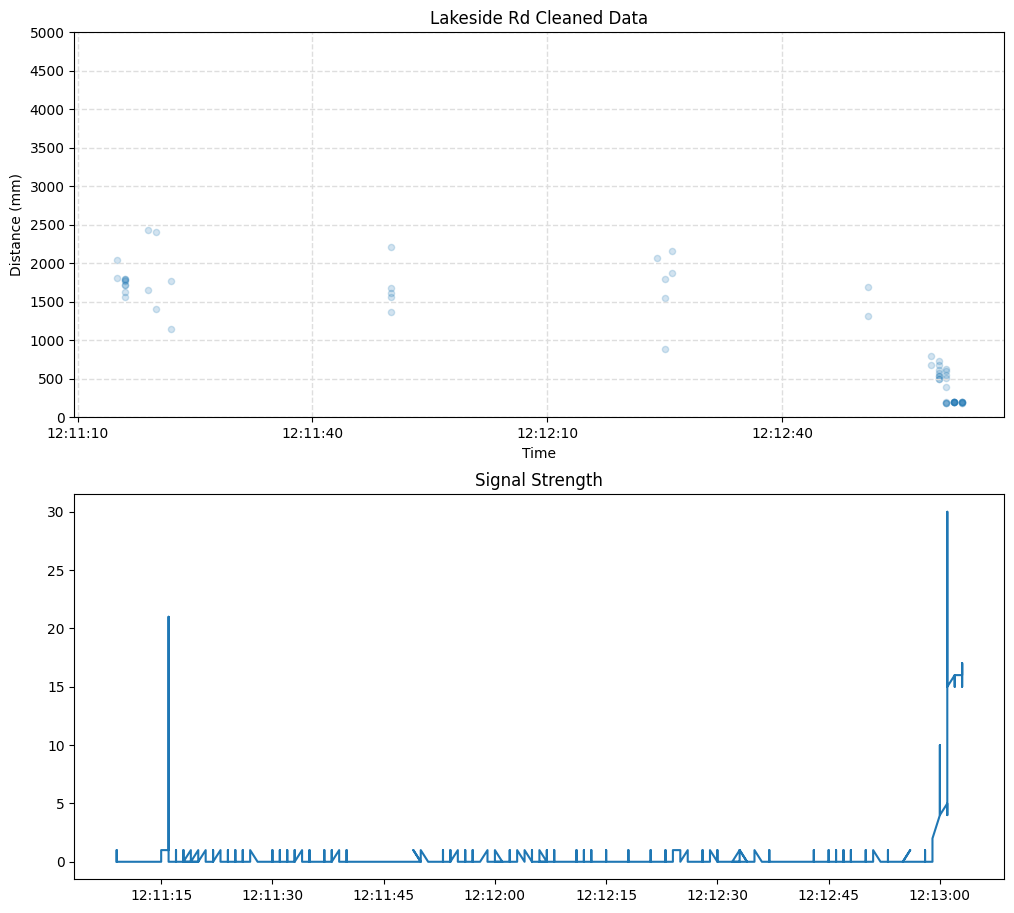

In [7]:
fig, axes = plt.subplots(2, figsize=(12, 11))

cleaned_distances = cleaner.clean_tof_data(distances)
outdoor_graphs.scatter_time_vs_distance(axes[0], timing, cleaned_distances, "Lakeside Rd Cleaned Data")

axes[1].plot(timing, strengths)
axes[1].set_title("Signal Strength")

plt.show()

- **Video-Assisted Analysis**:
  - The Gro Pro videofeed served as a reference for annotating the graph to specify the exact moments when vehicles maneuvered past the bike.
  - The foremost set of points emerged before the video feed initiation and prior to the bike's movement.
  - The sensor managed to register three distinct vehicles: a car in motion, a truck on the move, and a stationary truck towards the conclusion of the test. The dense cluster around the immobile truck can be attributed to its proximity to the bike and its stationary state.
  - Interestingly, the sensor missed detecting a motorbike, possibly due to its compact size.
  - At approximately 12:12:46, a couple of stray data points, which survived the cleaning process, are noticeable.

![Lakeside Rd Annotated](../assets/annotated_graphs/Lakeside_Rd.png)

## Conclusion

After testing and analysis in various settings, my investigation of the TOF sensor's capabilities yields several findings:

1. **Raw Data Observations**: The raw scatter plots consistently displayed a vast array of extraneous data points across different environments. This implies that the sensor tends to pick up considerable noise, particularly when used outdoors.
2. **Data Cleaning Efficacy**: The cleaning algorithm, designed to filter out anomalies and retain clusters indicative of passing vehicles, proved instrumental. Post-cleaning, the data emerged far more interpretable, underlining the significance of refining raw measurements.
3. **Sensor Reliability**: Despite its challenges, the TOF sensor exhibited notable proficiency in detecting larger vehicles. Factors such as size and proximity influenced its efficacy, evident from the dense cluster formations around larger, closer, or stationary vehicles. However, the sensor exhibited limitations when faced with smaller vehicles, such as motorbikes, or in scenarios with fast-moving traffic.
4. **Real-World Application**:On-road tests, like the one conducted on Lakeside Rd, further validated our findings from controlled environments. While the sensor demonstrated potential in lighter traffic scenarios, its reliability can be variable based on vehicular size and speed.

While the TOF sensor showcases potential, its limitations in outdoor daylight settings, particularly in distinguishing smaller or fast-moving vehicles, necessitate further refinements. Ensuring consistent data cleaning procedures can ameliorate some challenges, but achieving optimum reliability might require additional sensor improvements or complementary technologies. Overall, while the TOF is somewhat effective at measuring vehicle passes, I would opt for a sensor that is more robust and reliable.